In [80]:
import pandas as pd

In [82]:
customers = pd.read_excel('C:\\Users\\shiko\\Downloads\\E-commerce_data.xlsx', sheet_name='customers')
genders = pd.read_excel('C:\\Users\\shiko\\Downloads\\E-commerce_data.xlsx', sheet_name='genders')
cities = pd.read_excel('C:\\Users\\shiko\\Downloads\\E-commerce_data.xlsx', sheet_name='cities')
transactions = pd.read_excel('C:\\Users\\shiko\\Downloads\\E-commerce_data.xlsx', sheet_name='transactions')
branches = pd.read_excel('C:\\Users\\shiko\\Downloads\\E-commerce_data.xlsx', sheet_name='branches')
merchants = pd.read_excel('C:\\Users\\shiko\\Downloads\\E-commerce_data.xlsx', sheet_name='merchants')

In [83]:
data = transactions.merge(customers, on='customer_id') \
                   .merge(genders, on='gender_id') \
                   .merge(cities, on='city_id') \
                   .merge(branches, on='branch_id') \
                   .merge(merchants, on='merchant_id')

In [84]:
import numpy as np
import matplotlib.pyplot as plt

In [85]:
data = transactions.merge(customers, on='customer_id')

In [93]:
features = data.groupby('customer_id').agg({
    'transaction_id': 'count',  # Total Coupons Claimed
    'transaction_date': 'max',  # Last Coupon Claim Date
}).reset_index()

features.rename(columns={'transaction_id': 'total_claimed'}, inplace=True)
features['recency'] = (pd.to_datetime('today') - pd.to_datetime(features['transaction_date'])).dt.days
features['frequency'] = features['total_claimed'] / features['recency']  # Frequency of claims

In [95]:
#unnessecary
features.drop(columns=['transaction_date'], inplace=True)

***standarize***

In [98]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features[['total_claimed', 'recency', 'frequency']])

*****#kmeans*****

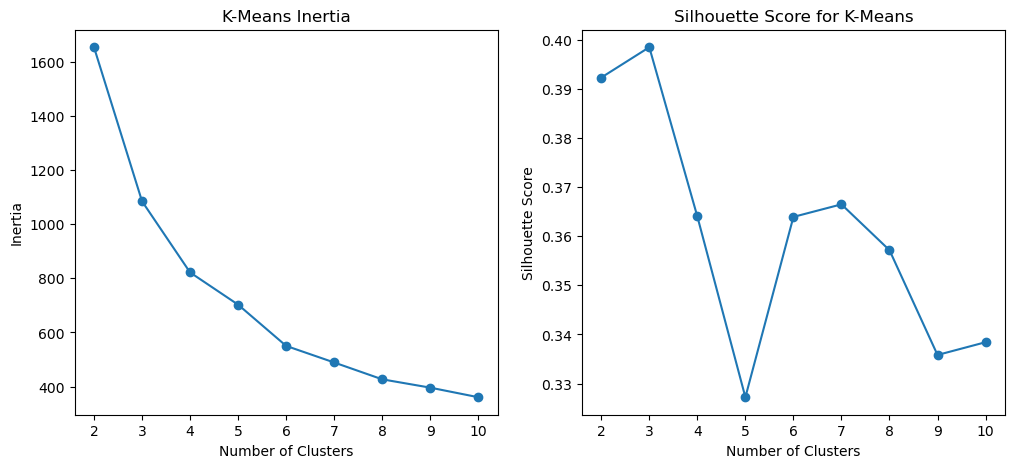

In [101]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

inertia = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(scaled_features, kmeans.labels_))

# Plotting Inertia and Silhouette Score
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, marker='o')
plt.title('K-Means Inertia')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')

plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, marker='o')
plt.title('Silhouette Score for K-Means')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [103]:
optimal_k =5
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
features['kmeans_cluster'] = kmeans.fit_predict(scaled_features)

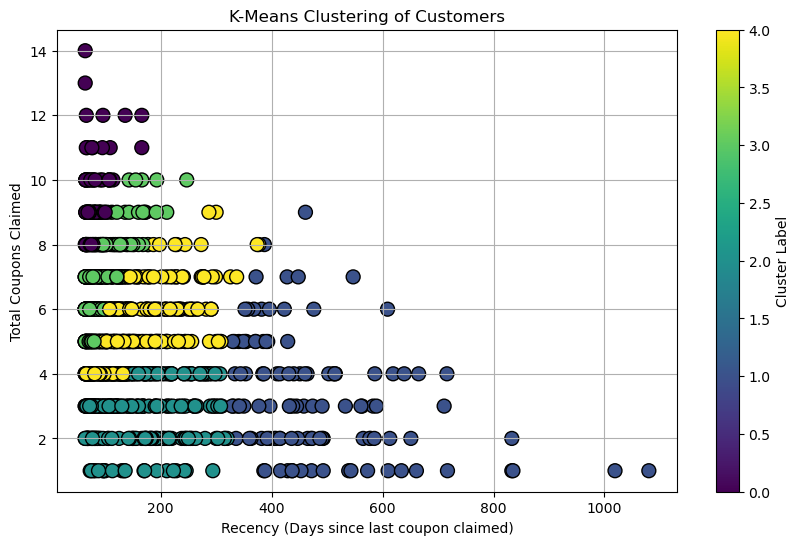

In [105]:
plt.figure(figsize=(10, 6))
plt.scatter(features['recency'], features['total_claimed'], 
            c=features['kmeans_cluster'], cmap='viridis', marker='o', edgecolor='k', s=100)

plt.title('K-Means Clustering of Customers')
plt.xlabel('Recency (Days since last coupon claimed)')
plt.ylabel('Total Coupons Claimed')
plt.colorbar(label='Cluster Label')
plt.grid(True)
plt.show()

****Hierarchical Clustering****

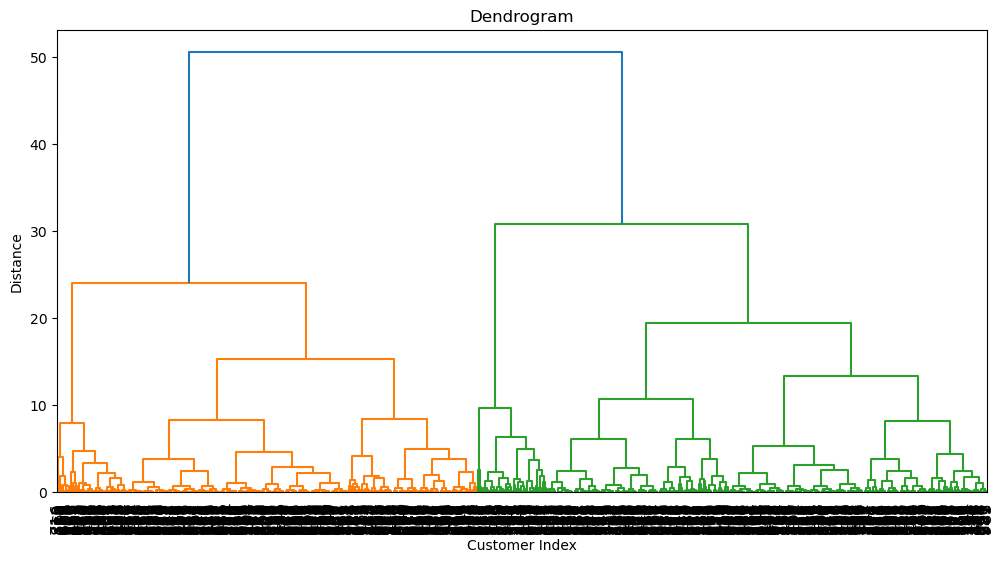

In [43]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

# Generate the linkage matrix
linkage_matrix = sch.linkage(scaled_features, method='ward')

# Plot the dendrogram
plt.figure(figsize=(12, 6))
sch.dendrogram(linkage_matrix, leaf_rotation=90, leaf_font_size=12)
plt.title('Dendrogram')
plt.xlabel('Customer Index')
plt.ylabel('Distance')
plt.show()

In [114]:
n_clusters = 5  # Choose based on dendrogram
hierarchical = AgglomerativeClustering(n_clusters=n_clusters)
features['hierarchical_cluster'] = hierarchical.fit_predict(scaled_features)

In [116]:
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(scaled_features, features['hierarchical_cluster'])
print(f'Silhouette Score for Hierarchical Clustering: {silhouette_avg:.3f}')

Silhouette Score for Hierarchical Clustering: 0.333


In [118]:
segment_analysis = features.groupby('hierarchical_cluster').agg({
    'total_claimed': 'mean',
    'recency': 'mean',
    'frequency': 'mean',
}).reset_index()
print(segment_analysis)

   hierarchical_cluster  total_claimed     recency  frequency
0                     0       6.093834   95.305630   0.066914
1                     1       2.857664  158.394161   0.022681
2                     2       2.453333  531.493333   0.004875
3                     3       9.310811   78.513514   0.122330
4                     4       5.549223  225.051813   0.027268


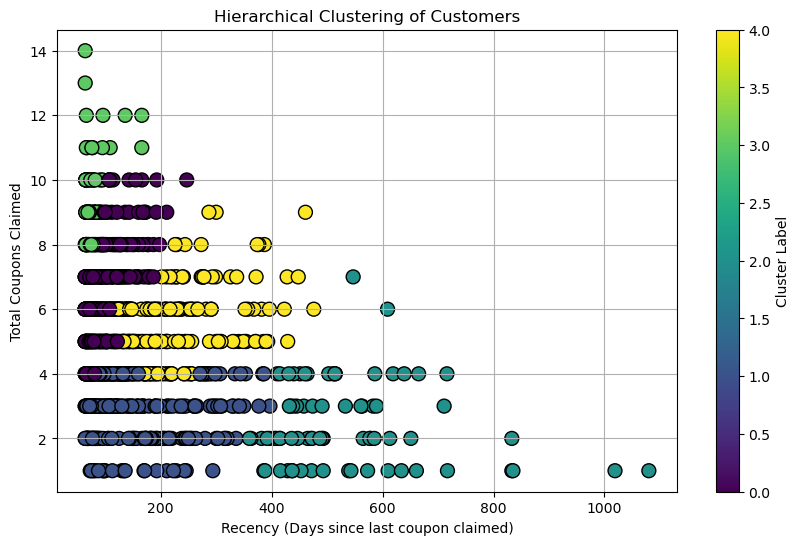

In [120]:
# Plotting the clusters
plt.figure(figsize=(10, 6))
plt.scatter(features['recency'], features['total_claimed'], 
            c=features['hierarchical_cluster'], cmap='viridis', marker='o', edgecolor='k', s=100)

plt.title('Hierarchical Clustering of Customers')
plt.xlabel('Recency (Days since last coupon claimed)')
plt.ylabel('Total Coupons Claimed')
plt.colorbar(label='Cluster Label')
plt.grid(True)
plt.show()